In [237]:
import matplotlib.pyplot as plt
import numpy as np
import random as rand

Numerically Simulate using Euler-Maruyama scheme

X_new = b(X_old)delta_t + sigma(X_old)del_W

where: delta_t = t_new/n, and delta_W ~ N(0, del_t_)

in this example: b = x - x^3 and sigma = 1/(1+0.3x^2)^2 and X_0 = 1

In [238]:
# params 
run_time = 3.0
n = 300
del_t = run_time/n
num_sims = 1000000

results = np.zeros((num_sims, n))
results[:, 0] = 1.


In [245]:
for j in range(1, n):
    drift_term = (results[:, j-1] - (results[:, j-1]**3))*del_t
    diffusion_term = 1/(1+ 0.3*(results[:, j-1]**2)**2)
    del_W = np.random.normal(0, del_t, size=num_sims)
    diffusion_term = diffusion_term*del_W
    results[:, j] = results[:, j-1] + drift_term + diffusion_term
print('complete')

complete


In [246]:
y_ax = np.sum(results, axis=0)/num_sims
x_ax = np.arange(start=0, stop=run_time, step=del_t)

<function matplotlib.pyplot.show(close=None, block=None)>

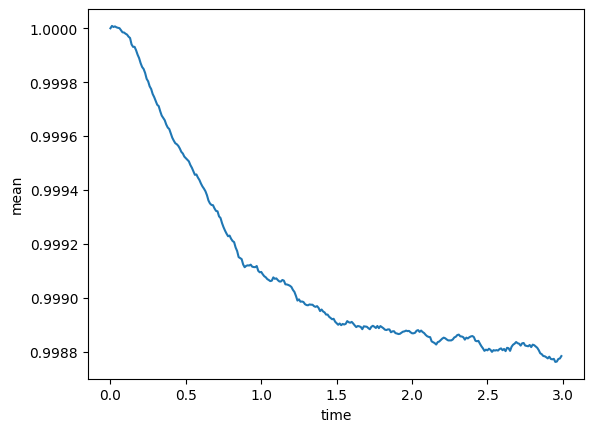

In [247]:
plt.plot(x_ax, y_ax)
plt.xlabel('time')
plt.ylabel('mean')
plt.show

In [243]:
time = results[:, 299]

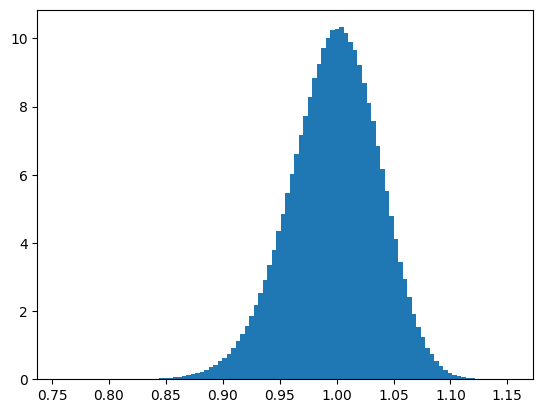

In [244]:
plt.hist(time, bins=100, density=True)
plt.show()